# Real-world Data Wrangling Project

In [58]:
#Import required Python packages for this exercise
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import seaborn as sns
import matplotlib.pyplot as plt
import openpyxl
import wbgapi as wb

## 1. Gather data

In this section, you will extract data using two different data gathering methods and combine the data. Use at least two different types of data-gathering methods.

### **1.1.** Problem Statement
This project aims to seamlessly integrate global happiness levels, life expectancy, and a suite of socio-economic indicators from the World Happiness Report, World Population Review, and the World Bank Open Data API into a cohesive dataset. The primary objective is to prepare this data, specifically for the 2024/2025 period, to facilitate an in-depth exploration of the interrelationships between these national well-being metrics. The core challenge involves meticulous data wrangling to harmonize country names as the primary identifier across all three disparate sources, while also diligently addressing any data quality issues to yield a clean, unified dataset ready for robust analysis.


Questions to be answered:
1. Are the top 10 countries that are happiest have a high life expectancy?
2. How does unemployment rate affect the life expectancy and happiness?
3. Do happier countries bring in more GDP per capita?

### **1.2.** Gather datasets using different data gathering methods

#### **Dataset 1: World Happiness Report data 2025**
Reason for choice: This dataset is the authoritative source for global happiness scores and their key drivers as perceived by individuals, providing a direct measure of subjective well-being essential for our primary research question. Its structured format and yearly updates make it a reliable foundation for happiness analysis.

Type: Excel (.xlsx) file

Method: The data was gathered using the "Downloading files" method from (https://www.worldhappiness.report/data-sharing/) source as an xlsx file

Dataset variables:

*   Year: Represents the year for which this data pertains to

*   Rank: The country's global ranking based on its Ladder score in that particular year, from highest (happiest) to lowest.

*   Country name:  The official name of the country for which happiness data is reported. This is the primary unique identifier.

*   Ladder score: The central measure of happiness for each country. It's the average response to the Cantril Ladder question, where respondents rate their life from 0 (worst) to 10 (best).

*   upperwhisker: The upper bound of the 95% confidence interval for the Ladder score.

*   lowerwhisker: The lower bound of the 95% confidence interval for the Ladder score.

*   Explained by: Log GDP per capita: The portion of the Ladder score that is explained by the natural logarithm of a country's GDP per capita (adjusted for Purchasing Power Parity). It represents the estimated contribution of economic production to happiness.

*   Explained by: Social support: The portion of the Ladder score explained by the perceived availability of social support from family and friends. It reflects the estimated contribution of social connections to happiness.

*   Explained by: Healthy life expectancy: The portion of the Ladder score explained by the average number of years a person is expected to live in good health. It represents the estimated contribution of health outcomes to happiness.

*   Explained by: Freedom to make life choices: The portion of the Ladder score explained by the perceived freedom of individuals to make life decisions. It reflects the estimated contribution of personal liberty to happiness.

*   Explained by: Generosity: The portion of the Ladder score explained by a country's average generosity, often measured by charitable donations after accounting for GDP. It represents the estimated contribution of altruism to happiness.

*   Explained by: Perceptions of corruption: The portion of the Ladder score explained by the perceived absence of corruption in government and business. It reflects the estimated contribution of institutional trust and integrity to happiness.

*   Dystopia + residual: Represents the baseline happiness level (Dystopia) plus any happiness that cannot be explained by the standard six factors, indicating the influence of unmeasured variables specific to that country. This value can be positive or negative

In [2]:
#input file location
file_loc = 'Input/WHR25_Data_Figure_2.1.xlsx'

#read the xlsx file into a dataframe
df1 = pd.read_excel(file_loc)

#display first 5 rows
df1.head()

,Year,Rank,Country name,Ladder score,upperwhisker,lowerwhisker,Explained by: Log GDP per capita,Explained by: Social support,Explained by: Healthy life expectancy,Explained by: Freedom to make life choices,Explained by: Generosity,Explained by: Perceptions of corruption,Dystopia + residual
0,2024,1,Finland,7.736,7.810,7.662,1.749,1.783,0.824,0.986,0.110,0.502,1.782
1,2023,143,Afghanistan,1.721,1.775,1.667,0.628,0.000,0.242,0.000,0.091,0.088,0.672
2,2022,137,Afghanistan,1.859,1.923,1.795,0.645,0.000,0.087,0.000,0.093,0.059,0.976
3,2021,146,Afghanistan,2.404,2.469,2.339,0.758,0.000,0.289,0.000,0.089,0.005,1.263
4,2020,150,Afghanistan,2.523,2.596,2.449,0.370,0.000,0.126,0.000,0.122,0.010,1.895


In [3]:
#dataset has data for all years. Filter to only relevant 2024 data
df1 = df1[df1['Year']==2024]

In [4]:
#Create a copy of the original dataset to prevent any updates to this.
orig_df1 = df1.copy()
orig_df1.to_csv('Output/WHR25Data_Original.csv',index=False)

#### **Dataset 2: Life expectancy by country for 2025**
Reason for choice: This dataset provides up-to-date and specific life expectancy figures, including gender breakdowns, making it a critical, complementary source for assessing health outcomes at a national level. Its web-based format necessitates web scraping, fulfilling a key project requirement for diverse data gathering methods.

Type: Web Scraping using BeautifulSoup

Method: The data was gathered using the "Web Scraping" method from (https://worldpopulationreview.com/country-rankings/life-expectancy-by-country) source

Dataset variables:

*   Country
*   Life Expectancy, Both Sexes - UN 2024
*   LE, Female - UN 2024
*   LE, Male - UN 2024

In [5]:
#define the url to obtain the data from
url = "https://worldpopulationreview.com/country-rankings/life-expectancy-by-country"

#send request to get the data from the URL
parsed_data = requests.get(url)

#raise an error for bad response 
parsed_data.raise_for_status()

#convert to text
content= parsed_data.text
print("Successfully fetched website content")

Successfully fetched website content


In [6]:
#Parse the fetched content using BeautifulSoup
soup = BeautifulSoup(content,'html.parser')
print("Successfully parsed the content")

#print(soup.prettify())

Successfully parsed the content


In [7]:
#look for the tables tag to identify the data we need
table=soup.find_all('table')
table

[<table class="wpr-table min-w-full border-collapse"><thead class="table-head bg-wpr-table_header_bg relative z-40 px-0 py-0 text-xs tracking-wider uppercase"><tr><th class="datatable-th border-wpr-table_border bg-wpr-table_header_bg text-wpr-table_header sticky top-0 z-40 border-none py-2 leading-4 w-12 px-2 text-center"><div class="flex cursor-pointer items-center select-none justify-center"><span class="sort-indicator ml-1"></span></div></th><th class="datatable-th border-wpr-table_border bg-wpr-table_header_bg text-wpr-table_header sticky top-0 z-40 border-none py-2 leading-4 px-3 text-left md:px-4"><div class="flex cursor-pointer items-center select-none">Country<span class="sort-indicator ml-1"></span></div></th><th class="datatable-th border-wpr-table_border bg-wpr-table_header_bg text-wpr-table_header sticky top-0 z-40 border-none py-2 leading-4 px-3 text-left md:px-4"><div class="flex cursor-pointer items-center select-none">Life Expectancy, Both Sexes - UN 2024<span class="so

In [8]:
#isolate the first table tag data
target_table = table[0]

In [9]:
# 1. Isolate the table headers
headers=[]
# Look for headers in both thead and directly in tr if thead is missing
header_row = target_table.find('thead')
if header_row:
    for th in header_row.find_all('th'):
        headers.append(th.text.strip())
else: # Fallback if no thead, look for th in the first tr of tbody or directly in table
    first_row = target_table.find('tr')
    if first_row:
        for th in first_row.find_all(['th', 'td']): # Sometimes headers are in td in the first row
            headers.append(th.text.strip())
headers

['',
 'Country',
 'Life Expectancy, Both Sexes - UN 2024â\x86\x93',
 'LE, Female - UN 2024',
 'LE, Male - UN 2024']

In [10]:
# 2. Extract the table rows and cell data
data_rows = []
for row in target_table.find_all('tr'):
    # Skip header rows since they've already been processed
    if row.find_parent('thead'):
        continue

    cols = row.find_all(['td', 'th']) # Get all data cells (td) and potentially more headers (th)
    cols = [ele.text.strip() for ele in cols]
    if cols: # Only add non-empty rows
        data_rows.append(cols)

#data_rows

In [11]:
# 3. Create the pandas dataframe
if headers:
    df2=pd.DataFrame(data_rows,columns=headers)
else:
    df2=pd.DataFrame(data_rows)

print("Dataframe successfully created from web scraping")
#df2.info()

Dataframe successfully created from web scraping


In [12]:
#Create a copy of the original dataset to prevent any updates to this.
orig_df2 = df2.copy()
orig_df2.to_csv('Output/LifeExpectancy_Data_Original.csv',index=False)

#### **Dataset 3: World Bank data for socioeconomic factors**
Reason for choice: The World Bank API offers a vast repository of reliable, cross-country economic and social indicators, which are crucial for a deeper contextual analysis of happiness and life expectancy beyond the intrinsic factors. Its programmatic access via wbgapi allows for efficient and precise data extraction of specific indicators for all countries, demonstrating advanced data acquisition skills.

Type: WorldBank API

Method: The data was gathered using the "API" method from (https://data.worldbank.org/country/1W) source

Dataset variables:

*   Country Code
*   Country Name
*   GDP per capita (current US$): (NY.GDP.PCAP.CD)
*   Gini index (World Bank estimate): (SI.POV.GINI)
*   Current health expenditure (% of GDP): (SH.XPD.CHEX.GD.ZS)
*   Government expenditure on education, total (% of GDP): (SE.XPD.TOTL.GD.ZS)
*   Unemployment rate, total (% of total labor force): (SL.UEM.TOTL.ZS)
*   Control of Corruption: Estimate: (CC.EST)
*   Women making their own informed decisions regarding sexual relations, contraceptive use and reproductive health care (% of women age 15-49): (SG.DMK.SRCR.FN.ZS)

In [13]:
# Determine the target year as 2024 to align with data from other datasets
target_year = 2024

#declare the specific indicators identified for the analysis
indicators = {
    'NY.GDP.PCAP.CD': 'GDP per capita (current US$)',
    'SI.POV.GINI': 'Gini index (World Bank estimate)',
    'SH.XPD.CHEX.GD.ZS': 'Current health expenditure (% of GDP)',
    'SE.XPD.TOTL.GD.ZS': 'Government expenditure on education, total (% of GDP)',
    'SL.UEM.TOTL.ZS': 'Unemployment rate, total (% of total labor force)',
    'CC.EST':'Control of Corruption: Estimate',
    'SG.DMK.SRCR.FN.ZS':'Women making their own informed decisions regarding sexual relations, contraceptive use and reproductive health care (% of women age 15-49)'
}

#initialize list
all_data=[]

In [14]:
#Fetch the World Bank data for all the indicators mentioned above for all countries
df3_raw = wb.data.DataFrame(
        indicators.keys(),
        economy='all', # Request data for all economies
        time=target_year,
        labels=True,
        columns='series'
)

df3_raw.head() 

,Country,CC.EST,NY.GDP.PCAP.CD,SE.XPD.TOTL.GD.ZS,SG.DMK.SRCR.FN.ZS,SH.XPD.CHEX.GD.ZS,SI.POV.GINI,SL.UEM.TOTL.ZS
economy,,,,,,,,
ZWE,Zimbabwe,NaN,2656.409377,NaN,NaN,NaN,NaN,8.554
ZMB,Zambia,NaN,1235.084665,NaN,NaN,NaN,NaN,5.961
YEM,"Yemen, Rep.",NaN,433.174015,NaN,NaN,NaN,NaN,17.086
PSE,West Bank and Gaza,NaN,2592.305912,NaN,NaN,NaN,NaN,NaN
VIR,Virgin Islands (U.S.),NaN,NaN,NaN,NaN,NaN,NaN,12.014


In [15]:
#Create a copy of the original dataset to prevent any updates to this.
orig_df3 = df3_raw.copy()
orig_df3.to_csv('Output/WorldBankData_Original.csv',index=False)

## 2. Assess data

Assess the data according to data quality and tidiness metrics using the report below.

List **two** data quality issues and **two** tidiness issues. Assess each data issue visually **and** programmatically, then briefly describe the issue you find.  **Make sure you include justifications for the methods you use for the assessment.**

### 2a. Assess *DF1: WHR Data*

In [16]:
#explore first few rows
df1.head()

,Year,Rank,Country name,Ladder score,upperwhisker,lowerwhisker,Explained by: Log GDP per capita,Explained by: Social support,Explained by: Healthy life expectancy,Explained by: Freedom to make life choices,Explained by: Generosity,Explained by: Perceptions of corruption,Dystopia + residual
0,2024,1,Finland,7.736,7.810,7.662,1.749,1.783,0.824,0.986,0.110,0.502,1.782
13,2024,2,Denmark,7.521,7.611,7.431,1.825,1.748,0.820,0.955,0.150,0.488,1.535
26,2024,3,Iceland,7.515,7.606,7.425,1.799,1.840,0.873,0.971,0.201,0.173,1.659
45,2024,4,Sweden,7.345,7.427,7.262,1.783,1.698,0.889,0.952,0.170,0.467,1.385
58,2024,5,Netherlands,7.306,7.372,7.240,1.822,1.667,0.844,0.860,0.186,0.344,1.583


In [17]:
#assess datatypes and missing values, if any
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 147 entries, 0 to 1956
Data columns (total 13 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Year                                        147 non-null    int64  
 1   Rank                                        147 non-null    int64  
 2   Country name                                147 non-null    object 
 3   Ladder score                                147 non-null    float64
 4   upperwhisker                                147 non-null    float64
 5   lowerwhisker                                147 non-null    float64
 6   Explained by: Log GDP per capita            147 non-null    float64
 7   Explained by: Social support                147 non-null    float64
 8   Explained by: Healthy life expectancy       146 non-null    float64
 9   Explained by: Freedom to make life choices  146 non-null    float64
 10  Explained by: Gene

In [18]:
#look for discrepancies in values
df1.describe()

,Year,Rank,Ladder score,upperwhisker,lowerwhisker,Explained by: Log GDP per capita,Explained by: Social support,Explained by: Healthy life expectancy,Explained by: Freedom to make life choices,Explained by: Generosity,Explained by: Perceptions of corruption,Dystopia + residual
count,147.0,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,146.000000,146.000000,147.000000,146.000000,144.000000
mean,2024.0,74.000000,5.578170,5.688701,5.467612,1.318701,1.333395,0.551493,0.749253,0.113442,0.146815,1.368819
std,0.0,42.579338,1.158278,1.148881,1.168702,0.393862,0.349952,0.218802,0.177694,0.059773,0.113880,0.521585
min,2024.0,1.000000,1.364000,1.427000,1.301000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.099000
25%,2024.0,37.500000,4.702500,4.828500,4.576500,1.037000,1.131000,0.414500,0.655000,0.066500,0.066500,1.103000
50%,2024.0,74.000000,5.868000,5.965000,5.747000,1.347000,1.438000,0.550500,0.767000,0.111000,0.118000,1.387000
75%,2024.0,110.500000,6.479000,6.570000,6.375000,1.648000,1.593500,0.713250,0.881250,0.150500,0.184500,1.678000
max,2024.0,147.000000,7.736000,7.810000,7.662000,2.028000,1.840000,0.948000,1.018000,0.323000,0.522000,2.701000


### **Data Issue 1**:

#### *Quality - Completeness*
This dataset is almost 99% clean with the only exception of 1 missing data point in the variables: Explained by: Healthy life expectancy, Explained by: Freedom to make life choices, Explained by: Perceptions of corruption and 4 missing values in Dystopia + residual.

We can treat these missing values by replacing the value wih the value of 0

### 2b. Assess *DF2: Life Expectancy by Country 2025 dataset*

In [19]:
#explore first few rows
df2.head()

,,Country,"Life Expectancy, Both Sexes - UN 2024â","LE, Female - UN 2024","LE, Male - UN 2024"
0,,Monaco,86.5,88.6,84.6
1,,San Marino,85.8,87.2,84.3
2,,Hong Kong,85.6,88.3,83
3,,Japan,84.8,87.9,81.8
4,,South Korea,84.4,87.3,81.3


In [20]:
#look for discrepancies in values
df2.describe()

,,Country,"Life Expectancy, Both Sexes - UN 2024â","LE, Female - UN 2024","LE, Male - UN 2024"
count,232,232,232,232,232
unique,1,232,150,151,146
top,,Monaco,74.7,84.5,79.5
freq,232,1,4,5,5


In [21]:
#assess datatypes and missing values, if any
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232 entries, 0 to 231
Data columns (total 5 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0                                             232 non-null    object
 1   Country                                   232 non-null    object
 2   Life Expectancy, Both Sexes - UN 2024â  232 non-null    object
 3   LE, Female - UN 2024                      232 non-null    object
 4   LE, Male - UN 2024                        232 non-null    object
dtypes: object(5)
memory usage: 9.2+ KB


In [22]:
#check if the country variable has all strings or if there are any numeric or other values present
df2['Country'].unique()

array(['Monaco', 'San Marino', 'Hong Kong', 'Japan', 'South Korea',
       'Saint Barthelemy', 'French Polynesia', 'Andorra', 'Switzerland',
       'Australia', 'Italy', 'Singapore', 'Spain', 'Liechtenstein',
       'Reunion', 'Gibraltar', 'Malta', 'France', 'Norway', 'Sweden',
       'Guernsey', 'Macau', 'Vatican City', 'United Arab Emirates',
       'Iceland', 'Martinique', 'Israel', 'Canada', 'Ireland', 'Portugal',
       'Qatar', 'Bermuda', 'Luxembourg', 'Netherlands', 'Belgium',
       'New Zealand', 'Guadeloupe', 'Austria', 'Denmark', 'Finland',
       'Greece', 'Puerto Rico', 'Cyprus', 'Slovenia', 'Germany',
       'United Kingdom', 'Bahrain', 'Chile', 'Maldives', 'Isle of Man',
       'Costa Rica', 'Kuwait', 'Cayman Islands', 'Saint Martin',
       'Faroe Islands', 'Oman', 'Czech Republic', 'Jersey', 'Albania',
       'Panama', 'Anguilla', 'United States', 'Falkland Islands',
       'Estonia', 'Saudi Arabia', 'Northern Mariana Islands',
       'New Caledonia', 'Poland', 'Croati

In [23]:
df2[''].unique()

array([''], dtype=object)

### **Data Issue 2**:

#### *Quality - Completeness*
The first column in the dataset has no name i.e. the name is blank for this column and it has only 1 unique value of ''. This column is not a variable with any valid data. It can be discarded.

### **Data Issue 3**:

#### *Quality - Validity*
There are three columns in the dataset, namely, 'Life Expectancy, Both Sexes - UN 2024â', 'LE, Female - UN 2024' and 'LE, Male - UN 2024' which are all of datatype object. But they should be identified as a float datatype since they store numeric values. 

### 2c. Assess *DF3_RAW: World Bank dataset*

In [24]:
#explore first few rows
df3_raw.head()

,Country,CC.EST,NY.GDP.PCAP.CD,SE.XPD.TOTL.GD.ZS,SG.DMK.SRCR.FN.ZS,SH.XPD.CHEX.GD.ZS,SI.POV.GINI,SL.UEM.TOTL.ZS
economy,,,,,,,,
ZWE,Zimbabwe,NaN,2656.409377,NaN,NaN,NaN,NaN,8.554
ZMB,Zambia,NaN,1235.084665,NaN,NaN,NaN,NaN,5.961
YEM,"Yemen, Rep.",NaN,433.174015,NaN,NaN,NaN,NaN,17.086
PSE,West Bank and Gaza,NaN,2592.305912,NaN,NaN,NaN,NaN,NaN
VIR,Virgin Islands (U.S.),NaN,NaN,NaN,NaN,NaN,NaN,12.014


In [25]:
#look for discrepancies in values
df3_raw.describe()

,CC.EST,NY.GDP.PCAP.CD,SE.XPD.TOTL.GD.ZS,SG.DMK.SRCR.FN.ZS,SH.XPD.CHEX.GD.ZS,SI.POV.GINI,SL.UEM.TOTL.ZS
count,0.0,232.000000,0.0,0.0,0.0,2.000000,230.000000
mean,NaN,18079.659452,NaN,NaN,NaN,40.350000,6.521012
std,NaN,24333.818824,NaN,NaN,NaN,7.707464,5.007064
min,NaN,153.930218,NaN,NaN,NaN,34.900000,0.126000
25%,NaN,2573.637587,NaN,NaN,NaN,37.625000,3.434000
50%,NaN,7656.379098,NaN,NaN,NaN,40.350000,5.077229
75%,NaN,23912.748187,NaN,NaN,NaN,43.075000,7.810413
max,NaN,138934.958846,NaN,NaN,NaN,45.800000,34.400000


In [26]:
#assess datatypes and missing values, if any
df3_raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 266 entries, ZWE to AFE
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Country            266 non-null    object 
 1   CC.EST             0 non-null      float64
 2   NY.GDP.PCAP.CD     232 non-null    float64
 3   SE.XPD.TOTL.GD.ZS  0 non-null      float64
 4   SG.DMK.SRCR.FN.ZS  0 non-null      float64
 5   SH.XPD.CHEX.GD.ZS  0 non-null      float64
 6   SI.POV.GINI        2 non-null      float64
 7   SL.UEM.TOTL.ZS     230 non-null    float64
dtypes: float64(7), object(1)
memory usage: 26.8+ KB


### **Data Issue 4**:

#### *Quality - Completeness*
The columns of 'CC.EST', 'SE.XPD.TOTL.GD.ZS','SG.DMK.SRCR.FN.ZS','SH.XPD.CHEX.GD.ZS','SI.POV.GINI' have no data at all. These columns are completely empty and can be removed from the dataset as there is no real value add. 

### **Data Issue 5**:

#### *Tidiness - Each variable forms a column*
The result for df3_raw displaying the first few rows shows that the df3_raw dataframe with the data from world bank dataset has one of the variable as the index as opposed to having it as the column. This violates the rule "Each variable forms a column". The index has to be reset to numeric values and the country code has to be structured as a column.

### **Data Issue 6**:

#### *Tidiness - Each type of observational unit forms a table*
The data for each country for the same year of 2024/2025 is currently spread across three separate datasets. A comprehensive dataset for the same observation unit has to be put together with the data for Country X in the same year 2024/2025 with its happiness, life expectancy, and economic indicators.

Merge these datasets.

### **Data Issue 7**:

#### *Quality - Consistency*
When talking about merging the three datasets together, note that the first dataset i.e. World happiness report has 147 unique countries in the dataset. While the Life expectancy dataset has 232 rows and the World bank data has 266 rows. The number of countries is not consistent across the three datasets.

There needs to be a base dataset or parent dataset to which the rest of the two datasets or dataframes will be merged to rectify the tidiness issue #6.

### **Additional Data Issues**:

1. The column names in dataframes df2 and df3_raw i.e. life expectancy data and World Bank data have to be renamed or reassigned to make the dataset more user-friendly and easy to comprehend. If the column names are hard to understand, the underlying data loses it's value too. Especially in large datasets. 

## 3. Clean data
Clean the data to solve the 4 issues corresponding to data quality and tidiness found in the assessing step. **Make sure you include justifications for your cleaning decisions.**

After the cleaning for each issue, please use **either** the visually or programatical method to validate the cleaning was succesful.

At this stage, you are also expected to remove variables that are unnecessary for your analysis and combine your datasets. Depending on your datasets, you may choose to perform variable combination and elimination before or after the cleaning stage. Your dataset must have **at least** 4 variables after combining the data.

### **Data Issue 1 - Fix**:

#### *Quality - Completeness*
Replace missing values with 0 in df1 i.e. World happiness report dataset for columns 'Explained by: Healthy life expectancy', 'Explained by: Freedom to make life choices', 'Explained by: Perceptions of corruption' and 'Dystopia + residual'.

In [27]:
#Fix Issue #1 by filling the missing values with 0

df1.fillna({'Explained by: Healthy life expectancy':0}, inplace=True)
df1.fillna({'Explained by: Freedom to make life choices':0}, inplace=True)
df1.fillna({'Explained by: Perceptions of corruption':0}, inplace=True)
df1.fillna({'Dystopia + residual':0}, inplace=True)

#validate the filling of missing values
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 147 entries, 0 to 1956
Data columns (total 13 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Year                                        147 non-null    int64  
 1   Rank                                        147 non-null    int64  
 2   Country name                                147 non-null    object 
 3   Ladder score                                147 non-null    float64
 4   upperwhisker                                147 non-null    float64
 5   lowerwhisker                                147 non-null    float64
 6   Explained by: Log GDP per capita            147 non-null    float64
 7   Explained by: Social support                147 non-null    float64
 8   Explained by: Healthy life expectancy       147 non-null    float64
 9   Explained by: Freedom to make life choices  147 non-null    float64
 10  Explained by: Gene

### **Data Issue 2 - Fix**:

#### *Quality - Completeness*
Remove the first column in the df2 dataframe i.e. Life expectancy data

In [28]:
#drop the first blank column
df2_new = df2.drop(columns=[''])

#verify that the first column is no longer present in the dataset
df2_new.head()

,Country,"Life Expectancy, Both Sexes - UN 2024â","LE, Female - UN 2024","LE, Male - UN 2024"
0,Monaco,86.5,88.6,84.6
1,San Marino,85.8,87.2,84.3
2,Hong Kong,85.6,88.3,83
3,Japan,84.8,87.9,81.8
4,South Korea,84.4,87.3,81.3


### **Data Issue 3 - Fix**:

#### *Quality - Validity*
There are three columns in the dataset, namely, 'Life Expectancy, Both Sexes - UN 2024â', 'LE, Female - UN 2024' and 'LE, Male - UN 2024' which are all of datatype object. But they should be identified as a float datatype since they store numeric values. 

In [29]:
#Identify the column names
df2_new.columns.to_list()

['Country',
 'Life Expectancy, Both Sexes - UN 2024â\x86\x93',
 'LE, Female - UN 2024',
 'LE, Male - UN 2024']

In [30]:
#rename the columns to address the additional issue
df2_new = df2_new.rename(columns={'Country': 'Country', 'Life Expectancy, Both Sexes - UN 2024â\x86\x93': 'LE_Both_Sex','LE, Female - UN 2024':'LE_Female','LE, Male - UN 2024':'LE_Male'})

#verify update
df2_new.head()

,Country,LE_Both_Sex,LE_Female,LE_Male
0,Monaco,86.5,88.6,84.6
1,San Marino,85.8,87.2,84.3
2,Hong Kong,85.6,88.3,83
3,Japan,84.8,87.9,81.8
4,South Korea,84.4,87.3,81.3


In [31]:
#change object type to float
df2_new['LE_Both_Sex']  = pd.to_numeric(df2_new['LE_Both_Sex'],errors='coerce')
df2_new['LE_Female']  = pd.to_numeric(df2_new['LE_Both_Sex'],errors='coerce')
df2_new['LE_Male']  = pd.to_numeric(df2_new['LE_Both_Sex'],errors='coerce')

#verify update to datatype
df2_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232 entries, 0 to 231
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Country      232 non-null    object 
 1   LE_Both_Sex  232 non-null    float64
 2   LE_Female    232 non-null    float64
 3   LE_Male      232 non-null    float64
dtypes: float64(3), object(1)
memory usage: 7.4+ KB


In [32]:
#verify no issues caused due to the datatype update
df2_new.describe()

,LE_Both_Sex,LE_Female,LE_Male
count,232.000000,232.000000,232.000000
mean,74.260345,74.260345,74.260345
std,7.023188,7.023188,7.023188
min,54.600000,54.600000,54.600000
25%,69.200000,69.200000,69.200000
50%,75.350000,75.350000,75.350000
75%,79.800000,79.800000,79.800000
max,86.500000,86.500000,86.500000


### **Data Issue 4 - Fix**:

#### *Quality - Completeness*
Drop the columns of 'CC.EST', 'SE.XPD.TOTL.GD.ZS','SG.DMK.SRCR.FN.ZS','SH.XPD.CHEX.GD.ZS','SI.POV.GINI' from the World bank dataset since they have no data at all and these columns are completely empty.

In [33]:
#drop the columns
df3_copy = df3_raw.drop(columns=['CC.EST', 'SE.XPD.TOTL.GD.ZS','SG.DMK.SRCR.FN.ZS','SH.XPD.CHEX.GD.ZS','SI.POV.GINI'])

#verify the change
df3_copy.head()

,Country,NY.GDP.PCAP.CD,SL.UEM.TOTL.ZS
economy,,,
ZWE,Zimbabwe,2656.409377,8.554
ZMB,Zambia,1235.084665,5.961
YEM,"Yemen, Rep.",433.174015,17.086
PSE,West Bank and Gaza,2592.305912,NaN
VIR,Virgin Islands (U.S.),NaN,12.014


### **Data Issue 5 - Fix**:

#### *Tidiness - Each variable forms a column*
Reset the index and rename the columns in World Bank Dataset to make it comprehensible and fix issue #5.

In [34]:
#create a copy of the df3_copy dataframe with the fixes for issue #5
df3 = df3_copy.copy().reset_index()
df3 = df3.rename(columns={'economy': 'CountryCode', 'Country': 'CountryName','NY.GDP.PCAP.CD':'GDP_PerCapita','SL.UEM.TOTL.ZS':'UnempRate'})
df3.head()

,CountryCode,CountryName,GDP_PerCapita,UnempRate
0,ZWE,Zimbabwe,2656.409377,8.554
1,ZMB,Zambia,1235.084665,5.961
2,YEM,"Yemen, Rep.",433.174015,17.086
3,PSE,West Bank and Gaza,2592.305912,NaN
4,VIR,Virgin Islands (U.S.),NaN,12.014


### **Remove unnecessary variables and combine datasets**

Depending on the datasets, you can also peform the combination before the cleaning steps.

### **Data Issue 6 & 7 - Fix**:

#### *6: Tidiness - Each type of observational unit forms a table*
#### *7: Quality - Consistency*
Create a comprehensive dataset from all the 3 dataframes to create one merged dataset to address issue # 6. Also, to address issue #7, set the World happiness report dataset i.e. df1 as the base dataset as this is the dataset with the happiness rankings for each country and forms the basis of the investigation for this project.

In [35]:
#Remove unnecessary variables from the world happiness report dataset. The unnecessary variables have already been removed from the other two datasets. 

df1_new = df1.drop(columns=['Year','upperwhisker','lowerwhisker']).copy()
df1_new.head()

,Rank,Country name,Ladder score,Explained by: Log GDP per capita,Explained by: Social support,Explained by: Healthy life expectancy,Explained by: Freedom to make life choices,Explained by: Generosity,Explained by: Perceptions of corruption,Dystopia + residual
0,1,Finland,7.736,1.749,1.783,0.824,0.986,0.110,0.502,1.782
13,2,Denmark,7.521,1.825,1.748,0.820,0.955,0.150,0.488,1.535
26,3,Iceland,7.515,1.799,1.840,0.873,0.971,0.201,0.173,1.659
45,4,Sweden,7.345,1.783,1.698,0.889,0.952,0.170,0.467,1.385
58,5,Netherlands,7.306,1.822,1.667,0.844,0.860,0.186,0.344,1.583


In [36]:
#join the world happiness data and the life expectancy data first.
df_interim = pd.merge(df1_new, df2_new, left_on=['Country name'], right_on=['Country'], how='left')

#join the interim dataset with the world bank data
final_df = pd.merge(df_interim, df3, left_on=['Country name'], right_on=['CountryName'], how='left')

#verify the merge
final_df.head()

,Rank,Country name,Ladder score,Explained by: Log GDP per capita,Explained by: Social support,Explained by: Healthy life expectancy,Explained by: Freedom to make life choices,Explained by: Generosity,Explained by: Perceptions of corruption,Dystopia + residual,Country,LE_Both_Sex,LE_Female,LE_Male,CountryCode,CountryName,GDP_PerCapita,UnempRate
0,1,Finland,7.736,1.749,1.783,0.824,0.986,0.110,0.502,1.782,Finland,82.1,82.1,82.1,FIN,Finland,53188.618625,8.260
1,2,Denmark,7.521,1.825,1.748,0.820,0.955,0.150,0.488,1.535,Denmark,82.1,82.1,82.1,DNK,Denmark,71851.756213,5.587
2,3,Iceland,7.515,1.799,1.840,0.873,0.971,0.201,0.173,1.659,Iceland,83.0,83.0,83.0,ISL,Iceland,82703.857994,3.107
3,4,Sweden,7.345,1.783,1.698,0.889,0.952,0.170,0.467,1.385,Sweden,83.4,83.4,83.4,SWE,Sweden,57723.234503,8.528
4,5,Netherlands,7.306,1.822,1.667,0.844,0.860,0.186,0.344,1.583,Netherlands,82.3,82.3,82.3,NLD,Netherlands,68218.726102,3.599


## 3. Additional Data Wrangling
Perform additional steps for data wrangling:

- Identify outliers in the data
- Perform feature engineering

### 3a. Outlier detection and correction

In [43]:
final_df.describe()

,Rank,Ladder score,Explained by: Log GDP per capita,Explained by: Social support,Explained by: Healthy life expectancy,Explained by: Freedom to make life choices,Explained by: Generosity,Explained by: Perceptions of corruption,Dystopia + residual,LE_Both_Sex,LE_Female,LE_Male,GDP_PerCapita,UnempRate
count,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,134.000000,134.000000,134.000000,128.000000,128.000000
mean,74.000000,5.578170,1.318701,1.333395,0.547741,0.744156,0.113442,0.145816,1.340884,74.066418,74.066418,74.066418,20470.912712,6.660539
std,42.579338,1.158278,0.393862,0.349952,0.222745,0.187557,0.059773,0.114133,0.551521,7.279407,7.279407,7.279407,26225.198268,5.645995
min,1.000000,1.364000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.099000,54.600000,54.600000,54.600000,508.371274,0.270000
25%,37.500000,4.702500,1.037000,1.131000,0.412500,0.652000,0.066500,0.065500,1.052000,68.700000,68.700000,68.700000,2686.600269,3.144000
50%,74.000000,5.868000,1.347000,1.438000,0.550000,0.767000,0.111000,0.118000,1.385000,75.400000,75.400000,75.400000,8441.025634,4.940500
75%,110.500000,6.479000,1.648000,1.593500,0.712500,0.880500,0.150500,0.183000,1.676000,79.800000,79.800000,79.800000,29551.770319,7.855000
max,147.000000,7.736000,2.028000,1.840000,0.948000,1.018000,0.323000,0.522000,2.701000,84.800000,84.800000,84.800000,137516.587324,34.400000


In [38]:
#Plot the boxplot to idenitfy any outliers for the numeric fields
numeric_fields = final_df.select_dtypes(include='number').columns.tolist()
print(numeric_fields)


['Rank', 'Ladder score', 'Explained by: Log GDP per capita', 'Explained by: Social support', 'Explained by: Healthy life expectancy', 'Explained by: Freedom to make life choices', 'Explained by: Generosity', 'Explained by: Perceptions of corruption', 'Dystopia + residual', 'LE_Both_Sex', 'LE_Female', 'LE_Male', 'GDP_PerCapita', 'UnempRate']


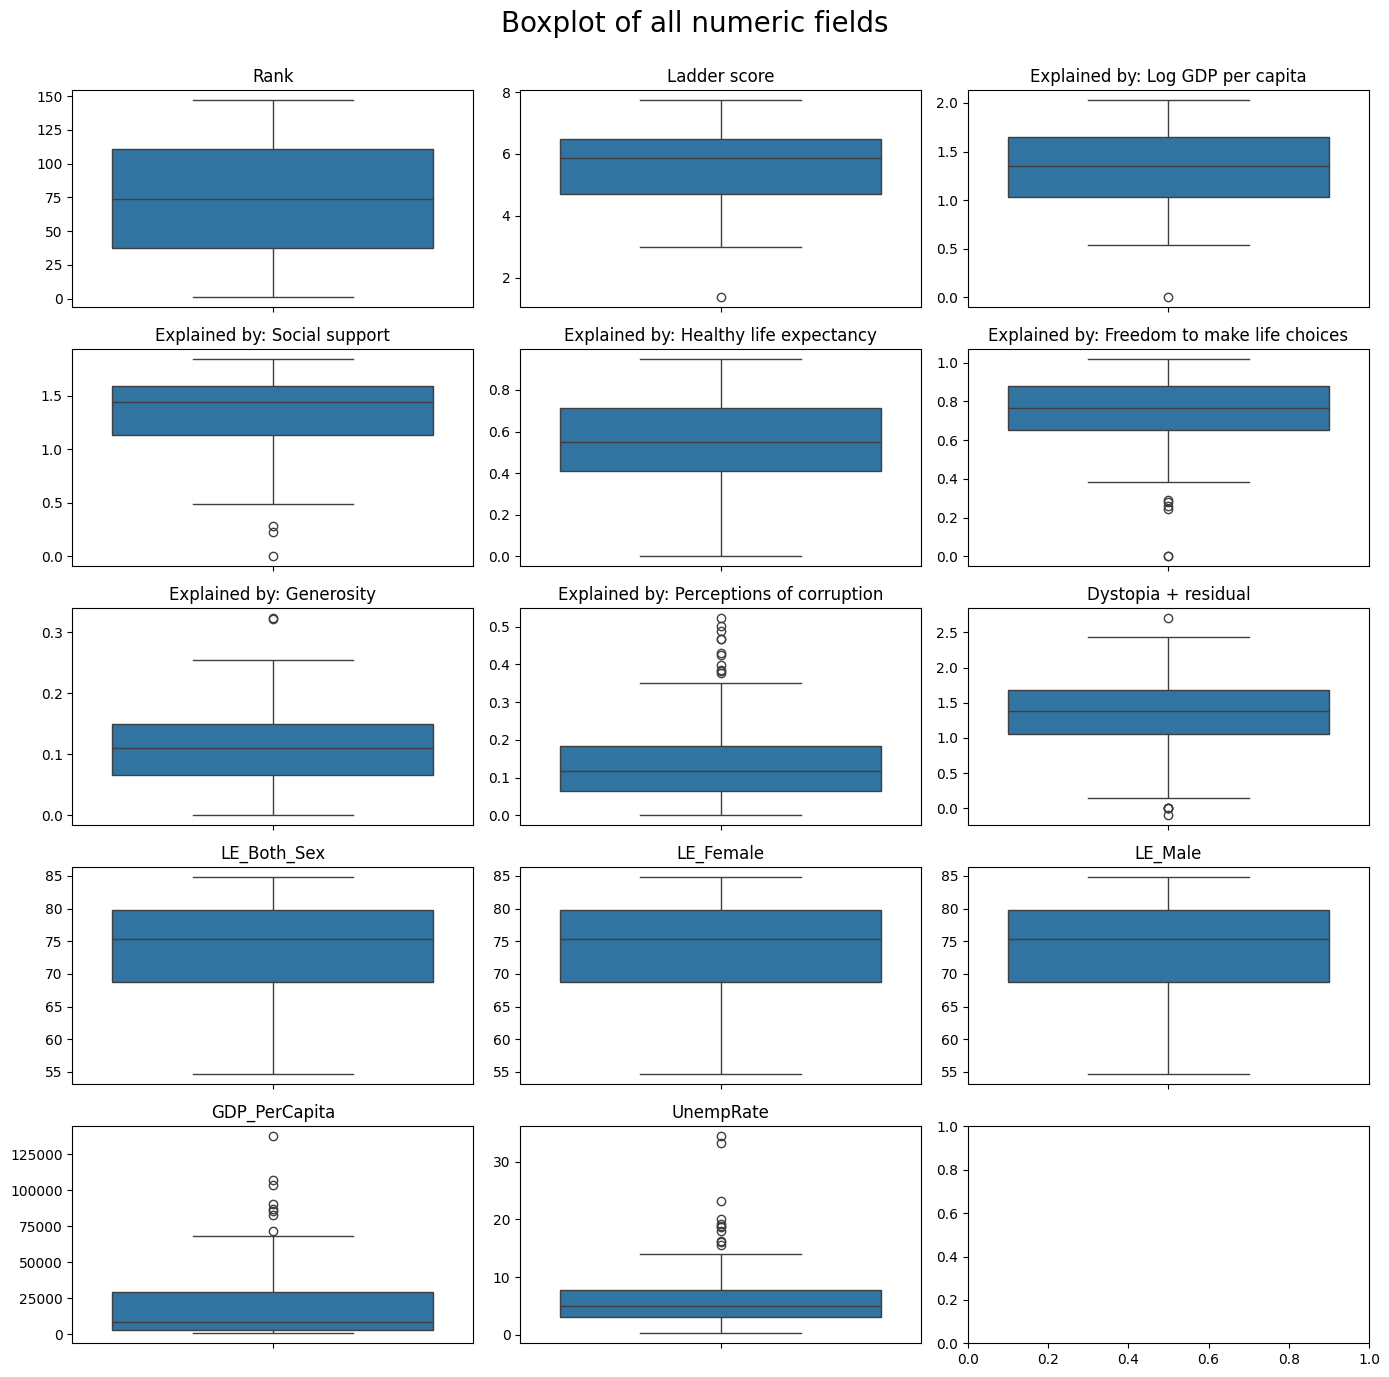

In [ ]:
#create boxplot for all the numeric fields
#initialize the plots for the numeric fields
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(14,14),sharex=False, sharey=False)
axes = axes.flatten()

#initialize a counter for the plots
i=0

#plot the boxplots
for col_name in numeric_fields:
    ax=axes[i]
    sns.boxplot(y=final_df[col_name], ax=ax) # This will plot a boxplot for each numeric column 
    ax.set_title(col_name)
    ax.set_ylabel('')
    i +=1
    
fig.suptitle('Boxplot of all numeric fields', fontsize=20)

plt.tight_layout(rect=[0, 0, 1, 0.98]) 

plt.show()

Based on the Boxplot, we see that 'Ladder score', 'Explained by: Log GDP per capita', 'Explained by: Social support','Explained by: Freedom to make life choices' , 'Explained by: Generosity', 'Explained by: Perceptions of corruption', 'Dystopia + residual', 'GDP_PerCapita', 'UnempRate' all have outliers.

However, the data being used is related to countries and pertains to real-world phenonmenon, especially in cases of unemployment rate of GDP values. These outliers don't necessarily mean inaccurate data or errors during data collection or entry. These could be genuine numbers representing the characteristics of a country and removing or dealing with these outliers would create an incomplete understanding. 

#### *Hence, it was decided to not remove the outleirs and keep them in the data to get a holistic representation of the real-world events.*

### 3b. Feauture engineering
- Create a categorical feature for "Life Expectancy Tier" (e.g., "Low", "Medium", "High")
- Create a "Happiness tier" for the Ladder score (e.g., "Low", "Medium", "High")

In [62]:
# Create 3 tiers for life expectancy: 'Low', 'Medium', 'High' based on quantiles
final_df['LE_Tier_Both_Sex'] = pd.qcut(
    final_df['LE_Both_Sex'],
    q=3, # Number of quantiles (3 for terciles)
    labels=['Low LE', 'Medium LE', 'High LE'], # Custom labels for the tiers
    duplicates='drop' # Handles cases where identical values might fall on quantile boundaries
)

# Create 3 tiers for Happiness tier: 'Low', 'Medium', 'High' based on quantiles
final_df['Happiness_Tier'] = pd.qcut(
    final_df['Ladder score'],
    q=3, # Number of quantiles (3 for terciles)
    labels=['Low', 'Medium', 'High'], # Custom labels for the tiers
    duplicates='drop' # Handles cases where identical values might fall on quantile boundaries
)

final_df.head()

,Rank,Country name,Ladder score,Explained by: Log GDP per capita,Explained by: Social support,Explained by: Healthy life expectancy,Explained by: Freedom to make life choices,Explained by: Generosity,Explained by: Perceptions of corruption,Dystopia + residual,Country,LE_Both_Sex,LE_Female,LE_Male,CountryCode,CountryName,GDP_PerCapita,UnempRate,LE_Tier_Both_Sex,Happiness_Tier
0,1,Finland,7.736,1.749,1.783,0.824,0.986,0.110,0.502,1.782,Finland,82.1,82.1,82.1,FIN,Finland,53188.618625,8.260,High LE,High
1,2,Denmark,7.521,1.825,1.748,0.820,0.955,0.150,0.488,1.535,Denmark,82.1,82.1,82.1,DNK,Denmark,71851.756213,5.587,High LE,High
2,3,Iceland,7.515,1.799,1.840,0.873,0.971,0.201,0.173,1.659,Iceland,83.0,83.0,83.0,ISL,Iceland,82703.857994,3.107,High LE,High
3,4,Sweden,7.345,1.783,1.698,0.889,0.952,0.170,0.467,1.385,Sweden,83.4,83.4,83.4,SWE,Sweden,57723.234503,8.528,High LE,High
4,5,Netherlands,7.306,1.822,1.667,0.844,0.860,0.186,0.344,1.583,Netherlands,82.3,82.3,82.3,NLD,Netherlands,68218.726102,3.599,High LE,High


In [63]:
final_df['LE_Tier_Both_Sex'].value_counts()

LE_Tier_Both_Sex
Low LE       46
Medium LE    46
High LE      42
Name: count, dtype: int64

In [64]:
final_df['Happiness_Tier'].value_counts()

Happiness_Tier
Low       49
Medium    49
High      49
Name: count, dtype: int64

## 4. Update your data store
Update your local database/data store with the cleaned data, following best practices for storing your cleaned data:

- Must maintain different instances / versions of data (raw and cleaned data)
- Must name the dataset files informatively
- Ensure both the raw and cleaned data is saved to your database/data store

In [65]:
#export the final_df to csv file
final_df.to_csv('Output/Combined_WHR_LE_WB_Data.csv',index=False)

## 5. Answer the research question

1. Do the top 10 countries that are happiest have a high life expectancy?
2. How does unemployment rate affect the life expectancy and happiness?
3. Do happier countries bring in more GDP per capita?

### **5.1:** Q1: Do the top 10 countries that are happiest have a high life expectancy?
Identify the top 10 happiest countries. Plot the life expectancy for these.

In [69]:
#Idenitfy the top 10 happiest countries by the rank
top_10_happiest = final_df[final_df['Rank']<=10]


,Rank,Country name,Ladder score,Explained by: Log GDP per capita,Explained by: Social support,Explained by: Healthy life expectancy,Explained by: Freedom to make life choices,Explained by: Generosity,Explained by: Perceptions of corruption,Dystopia + residual,Country,LE_Both_Sex,LE_Female,LE_Male,CountryCode,CountryName,GDP_PerCapita,UnempRate,LE_Tier_Both_Sex,Happiness_Tier
0,1,Finland,7.736,1.749,1.783,0.824,0.986,0.110,0.502,1.782,Finland,82.1,82.1,82.1,FIN,Finland,53188.618625,8.260,High LE,High
1,2,Denmark,7.521,1.825,1.748,0.820,0.955,0.150,0.488,1.535,Denmark,82.1,82.1,82.1,DNK,Denmark,71851.756213,5.587,High LE,High
2,3,Iceland,7.515,1.799,1.840,0.873,0.971,0.201,0.173,1.659,Iceland,83.0,83.0,83.0,ISL,Iceland,82703.857994,3.107,High LE,High
3,4,Sweden,7.345,1.783,1.698,0.889,0.952,0.170,0.467,1.385,Sweden,83.4,83.4,83.4,SWE,Sweden,57723.234503,8.528,High LE,High
4,5,Netherlands,7.306,1.822,1.667,0.844,0.860,0.186,0.344,1.583,Netherlands,82.3,82.3,82.3,NLD,Netherlands,68218.726102,3.599,High LE,High
5,6,Costa Rica,7.274,1.492,1.600,0.680,0.948,0.067,0.118,2.369,Costa Rica,81.0,81.0,81.0,CRI,Costa Rica,18587.153220,7.848,High LE,High
6,7,Norway,7.262,1.902,1.711,0.863,0.962,0.168,0.425,1.231,Norway,83.5,83.5,83.5,NOR,Norway,86809.724690,3.970,High LE,High
7,8,Israel,7.234,1.695,1.743,0.824,0.740,0.144,0.193,1.895,Israel,82.7,82.7,82.7,ISR,Israel,54176.684438,3.150,High LE,High
8,9,Luxembourg,7.122,2.028,1.558,0.864,0.931,0.117,0.397,1.227,Luxembourg,82.4,82.4,82.4,LUX,Luxembourg,137516.587324,5.935,High LE,High
9,10,Mexico,6.979,1.435,1.504,0.550,0.879,0.057,0.118,2.438,Mexico,75.3,75.3,75.3,MEX,Mexico,14157.944584,2.711,Medium LE,High


/var/folders/k9/6zk77nr12wn2r9x8z3txywgc0000gn/T/ipykernel_54753/3797611504.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='LE_Tier_Both_Sex', data=top_10_happiest, palette='viridis', order=['High LE','Medium LE', 'Low LE'])


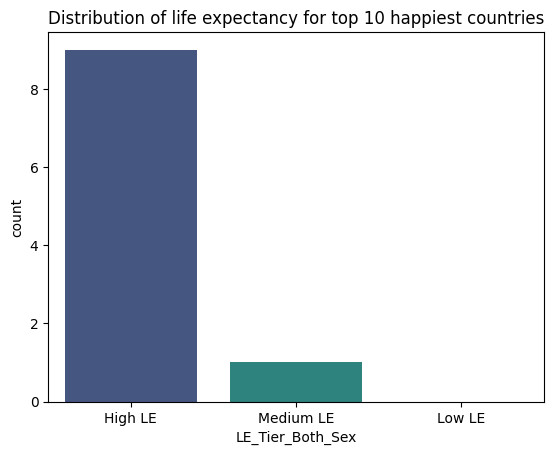

In [74]:
#plot the life expectancy tiers for these top 10 happiest countries
sns.countplot(x='LE_Tier_Both_Sex', data=top_10_happiest, palette='viridis', order=['High LE','Medium LE', 'Low LE'])
plt.title("Distribution of life expectancy for top 10 happiest countries")
plt.show()

In [75]:
top_10_happiest

,Rank,Country name,Ladder score,Explained by: Log GDP per capita,Explained by: Social support,Explained by: Healthy life expectancy,Explained by: Freedom to make life choices,Explained by: Generosity,Explained by: Perceptions of corruption,Dystopia + residual,Country,LE_Both_Sex,LE_Female,LE_Male,CountryCode,CountryName,GDP_PerCapita,UnempRate,LE_Tier_Both_Sex,Happiness_Tier
0,1,Finland,7.736,1.749,1.783,0.824,0.986,0.110,0.502,1.782,Finland,82.1,82.1,82.1,FIN,Finland,53188.618625,8.260,High LE,High
1,2,Denmark,7.521,1.825,1.748,0.820,0.955,0.150,0.488,1.535,Denmark,82.1,82.1,82.1,DNK,Denmark,71851.756213,5.587,High LE,High
2,3,Iceland,7.515,1.799,1.840,0.873,0.971,0.201,0.173,1.659,Iceland,83.0,83.0,83.0,ISL,Iceland,82703.857994,3.107,High LE,High
3,4,Sweden,7.345,1.783,1.698,0.889,0.952,0.170,0.467,1.385,Sweden,83.4,83.4,83.4,SWE,Sweden,57723.234503,8.528,High LE,High
4,5,Netherlands,7.306,1.822,1.667,0.844,0.860,0.186,0.344,1.583,Netherlands,82.3,82.3,82.3,NLD,Netherlands,68218.726102,3.599,High LE,High
5,6,Costa Rica,7.274,1.492,1.600,0.680,0.948,0.067,0.118,2.369,Costa Rica,81.0,81.0,81.0,CRI,Costa Rica,18587.153220,7.848,High LE,High
6,7,Norway,7.262,1.902,1.711,0.863,0.962,0.168,0.425,1.231,Norway,83.5,83.5,83.5,NOR,Norway,86809.724690,3.970,High LE,High
7,8,Israel,7.234,1.695,1.743,0.824,0.740,0.144,0.193,1.895,Israel,82.7,82.7,82.7,ISR,Israel,54176.684438,3.150,High LE,High
8,9,Luxembourg,7.122,2.028,1.558,0.864,0.931,0.117,0.397,1.227,Luxembourg,82.4,82.4,82.4,LUX,Luxembourg,137516.587324,5.935,High LE,High
9,10,Mexico,6.979,1.435,1.504,0.550,0.879,0.057,0.118,2.438,Mexico,75.3,75.3,75.3,MEX,Mexico,14157.944584,2.711,Medium LE,High


##### *Based on the results above, 9 out of the 10 happies countries have a High life expectancy with values over 82. Only one country i.e. Mexico has a Meidum tier life expectancy with a value of 75.3*

### **5.1:** Q2: How does unemployment rate affect the life expectancy and happiness?
Create two separate scatterplots showing relation between unemployment rate v/s life expectancy tiers and unemployment rate v/s happiness tiers

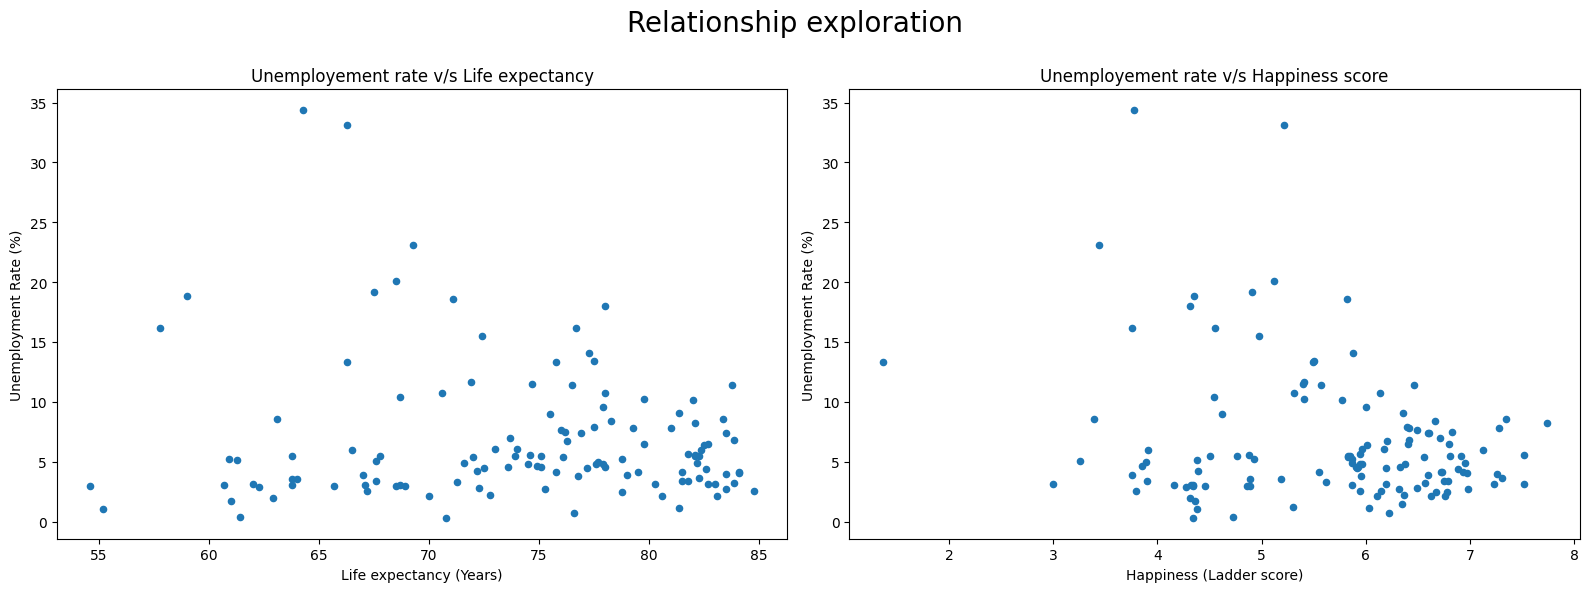

In [79]:
# --- Create the scatterplots ---
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6)) # 1 row, 2 columns for two plots

#create a scatter plot 1
final_df.plot(kind='scatter',
        x='LE_Both_Sex',
        y='UnempRate', ax=axes[0])

axes[0].set_title('Unemployement rate v/s Life expectancy')
axes[0].set_xlabel('Life expectancy (Years)')
axes[0].set_ylabel('Unemployment Rate (%)')

#create a scatter plot 2
final_df.plot(kind='scatter',
        x='Ladder score',
        y='UnempRate', ax=axes[1])

axes[1].set_title('Unemployement rate v/s Happiness score')
axes[1].set_xlabel('Happiness (Ladder score)')
axes[1].set_ylabel('Unemployment Rate (%)')


#initialize a counter for the plots
fig.suptitle('Relationship exploration', fontsize=20)

plt.tight_layout(rect=[0, 0, 1, 0.98]) 

plt.show()

##### *Based on the scatterplots above, there is a negeative correlation of both life expectancy and happiness score with the Unemployment rate*:
- Countries with lower unemployment rates tend to have higher life expectancies.
- Countries with lower unemployment rates tend to have higher happiness scores.

### **5.1:** Q3: Do happier countries bring in more GDP per capita?
Create a boxplot for the GDP per capita by the Happiness tiers to identify this relation

/var/folders/k9/6zk77nr12wn2r9x8z3txywgc0000gn/T/ipykernel_54753/2028405540.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Happiness_Tier', y='GDP_PerCapita',data=final_df, ax=ax, palette='viridis',


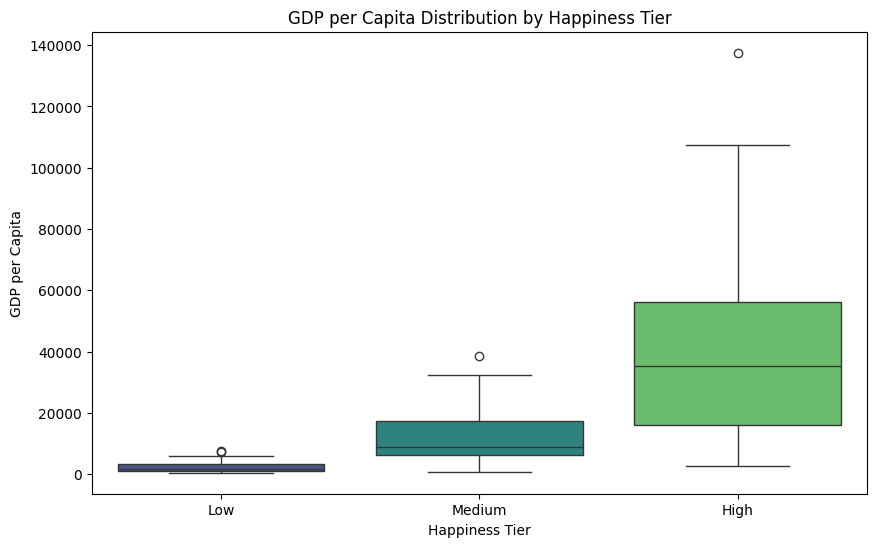

In [83]:
#create boxplot for all the numeric fields
#initialize the plots for the numeric fields
fig, ax = plt.subplots(figsize=(10,6))


#plot the boxplot
sns.boxplot(x='Happiness_Tier', y='GDP_PerCapita',data=final_df, ax=ax, palette='viridis',
            order=['Low','Medium','High']) 
ax.set_title('GDP per Capita Distribution by Happiness Tier')
ax.set_xlabel('Happiness Tier')
ax.set_ylabel('GDP per Capita')

plt.show()

##### *The results above show a clear upward progressions where countries with higher GDP per capita tend to have higher happiness scores* 

### **5.2:** Reflection
In 2-4 sentences, if you had more time to complete the project, what actions would you take? For example, which data quality and structural issues would you look into further, and what research questions would you further explore?

Given more time, I would then investigate specific outlier countries in greater detail, particularly those that defy the general trends, to understand their unique characteristics. eg: Mexico.

Further research questions I would want to explore would be by bringing in additional metrics from the world bank dataset that has populated data and identify the relationship and trends of the happiness score and life expectancy against these metrics. 

In [85]:
# Running this cell will execute a bash command to convert this notebook to an .html file
!python -m nbconvert --to html DataWrangling_Project.ipynb

[NbConvertApp] Converting notebook DataWrangling_Project.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 4 image(s).
[NbConvertApp] Writing 949377 bytes to DataWrangling_Project.html
